# CPSC 330 Lecture 17

### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- Today's dataset (5 min)
- Train/test splits with temporal data (15 min)
- Encoding date/time as feature(s) (20 min)
- Break (5 min)
- Lag-based features (15 min)
- Forecasting further into the future (10 min)
- Trends (5 min)
- What did we not cover? (10 min)

Piazza:

- T/F questions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, TimeSeriesSplit

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
from datetime import datetime

## Today's dataset (5 min)

[Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset. Predicting whether or not it will rain tomorrow based on today's measurements.

In [4]:
df_rain = pd.read_csv("data/weatherAUS.csv")
df_rain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


#### Goals

- Can the date/time features help us predict the target value?
- Can we **forecast** into the future?

Fun fact:

In [5]:
df_rain["Rainfall"].max()

371.0

3.7 metres of rain in one day?!?

#### Parsing datetimes 

- In general, datetimes are a huge pain! Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
- No, seriously, dealing with datetimes is THE WORST.
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [6]:
dates_rain = pd.to_datetime(df_rain["Date"])
dates_rain

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
142188   2017-06-20
142189   2017-06-21
142190   2017-06-22
142191   2017-06-23
142192   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

In [7]:
dates_rain[1] - dates_rain[0]

Timedelta('1 days 00:00:00')

They are all the same format, so we can also compare dates from the two datasets:

In [8]:
dates_rain[1] - dates_rain[0]

Timedelta('1 days 00:00:00')

In [9]:
dates_rain[1] > dates_rain[0]

True

In [10]:
(dates_rain[1] - dates_rain[0]).total_seconds()

86400.0

You can tell pandas to parse the dates when reading in the CSV:

In [11]:
df_rain = pd.read_csv("data/weatherAUS.csv", parse_dates=["Date"])
df_rain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [12]:
df_rain["Date"].head()

0   2008-12-01
1   2008-12-02
2   2008-12-03
3   2008-12-04
4   2008-12-05
Name: Date, dtype: datetime64[ns]

## Train/test splits with temporal data (15 min)

Let's do the usual thing we do...

In [13]:
df_train, df_test = train_test_split(df_rain, random_state=123)

In [14]:
def preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features):

    all_features = set(numeric_features + categorical_features + drop_features)
    if set(df_train.columns) != all_features:
        print("Missing columns", set(df_train.columns) - all_features)
        print("Extra columns", all_features - set(df_train.columns))
        raise Exception("Columns do not match")
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])  
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])
    preprocessor.fit(df_train);

    ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
    ohe_feature_names = list(ohe.get_feature_names(categorical_features))
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(preprocessor.transform(df_train).toarray(), index=df_train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(preprocessor.transform(df_test).toarray(),  index=df_test.index,  columns=new_columns)
    
    y_train = df_train["RainTomorrow"]
    y_test  = df_test["RainTomorrow"]
    
    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [15]:
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                    'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
drop_features = ['RISK_MM', 'Date', 'RainTomorrow']  # See the documentation, should not keep the column

In [16]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features, categorical_features, drop_features)

In [17]:
X_train_enc

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_?,RainToday_No,RainToday_Yes
88012,0.924831,-0.480941,3.135864,-0.119919,0.148454,5.866872,4.300843,7.821727,0.799900,2.314880,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
126827,-0.387306,-0.691473,-0.179868,-0.307113,1.305477,1.604277,1.359141,-0.417811,-0.783708,-0.558442,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
51624,-1.777546,-2.824857,-0.250919,-0.119919,0.148454,1.223688,0.340859,0.039941,0.060883,0.025962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
138778,1.502795,1.484018,-0.274603,-0.182317,0.871594,-0.527021,-0.111710,0.383255,0.219244,0.074663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23423,0.549935,0.150653,-0.274603,0.316865,0.148454,-0.755374,0.340859,-0.417811,-0.836495,0.464266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129130,-0.715340,-0.902004,-0.274603,-1.305478,-1.550923,0.310275,-0.337995,-0.646687,0.166457,-0.071439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
119906,-0.215478,-0.537083,0.767484,-0.244715,1.124692,-0.679256,0.114575,-0.417811,-0.678134,-0.168839,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
17730,0.706141,-0.242339,1.359579,-0.119919,0.148454,1.223688,1.132856,1.642074,1.063835,1.486973,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28030,0.221900,-1.112535,0.459595,-0.119919,0.148454,1.299806,-0.903707,-0.188935,1.591704,0.805168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now we do the modelling:

In [18]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [19]:
lr_pipe.fit(df_train, y_train);

In [20]:
lr_pipe.score(df_train, y_train)

0.8488241251265894

In [21]:
lr_pipe.score(df_test, y_test)

0.8482095136290754

- But, wait a minute, I did something wrong. Any ideas?

<br><br><br><br><br><br>

- Let's look at the dates in our train/test split:

In [22]:
df_train["Date"].max()

Timestamp('2017-06-25 00:00:00')

In [23]:
df_test["Date"].min()

Timestamp('2007-11-03 00:00:00')

- So, we are training on data that came before our test data!
- If we want to forecast, we aren't allowed to know what happened in the future!
- There may be cases where this is OK, e.g. if you aren't trying to forecast and just want to understand your data (maybe you're not even splitting).
- But, for our purposes, we want to avoid this.

In [24]:
# test_pred = df_test.sort_values(by=["Location", "Date"])
# np.mean(test_pred["RainToday"].iloc[1:].values == test_pred["RainTomorrow"].iloc[-1:].values)

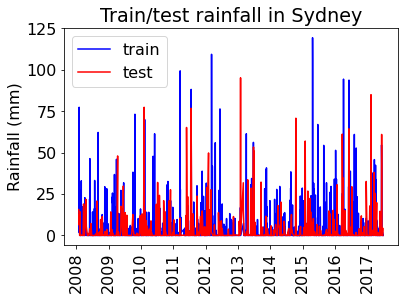

In [25]:
df_train_sort = df_train.query("Location == 'Sydney'").sort_values(by="Date")
df_test_sort = df_test.query("Location == 'Sydney'").sort_values(by="Date")

plt.plot(df_train_sort["Date"], df_train_sort["Rainfall"], 'b', label='train');
plt.plot(df_test_sort["Date"], df_test_sort["Rainfall"], 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();
plt.ylabel("Rainfall (mm)");
plt.title("Train/test rainfall in Sydney");

In [26]:
df_rain["Date"].min()

Timestamp('2007-11-01 00:00:00')

In [27]:
df_rain["Date"].max()

Timestamp('2017-06-25 00:00:00')

- It looks like we have 10 years of data.
- Let's use the last 2 years for test.

In [28]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [29]:
len(df_train)

107502

In [30]:
len(df_test)

34691

In [31]:
len(df_test)/(len(df_train)+len(df_test))

0.24397122221206388

As we can see, we're still using about 25% of our data as test data.

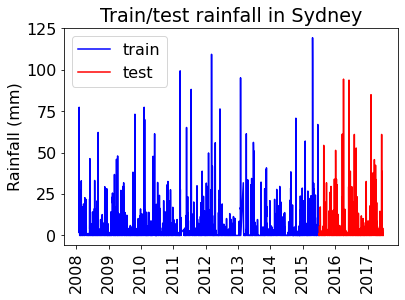

In [32]:
df_train_sort = df_train.query("Location == 'Sydney'").sort_values(by="Date")
df_test_sort = df_test.query("Location == 'Sydney'").sort_values(by="Date")

plt.plot(df_train_sort["Date"], df_train_sort["Rainfall"], 'b', label='train');
plt.plot(df_test_sort["Date"], df_test_sort["Rainfall"], 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();
plt.ylabel("Rainfall (mm)");
plt.title("Train/test rainfall in Sydney");

We're learning relationships from the blue part; predicting only using features in the red part from the day before.

In [33]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features, categorical_features, drop_features)

In [34]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [35]:
lr_pipe.fit(df_train, y_train);

In [36]:
lr_pipe.score(df_train, y_train)

0.8501888336961173

In [37]:
lr_pipe.score(df_test, y_test)

0.844368856475743

- In this case it didn't seem to really matter - we get about the same scores.
- However, in general we should split conservatively if we can.

In [38]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.243177
RainToday_?,0.918921
Pressure9am,0.865433
Location_Witchcliffe,0.728615
WindGustSpeed,0.720383
...,...
RainToday_No,-0.722747
Location_Katherine,-0.726450
Location_Wollongong,-0.749180
Location_MountGinini,-0.965270


In [39]:
dc = DummyClassifier(strategy='prior')
dc.fit(df_train, y_train);

In [40]:
dc.score(df_train, y_train)

0.7750553478074826

In [41]:
dc.score(df_test, y_test)

0.7781845435415525

#### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- Cross-validation randomly shuffles the rows, so you might get rows in your training set that occur after rows in your validation set. This isn't 100% terrible in that you're still predicting next week's price regardless, but it's not a good idea. Especially if there are trends in the dataset, and then you get to see what happened to the trend in the future.
- Actually, our training split is a bit weird because we "have the answers" in the training set. But our testing procedure is conservative.
- If we want, there is:

In [42]:
from sklearn.model_selection import TimeSeriesSplit

see https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split

However, things are actually more complicated here because this dataset has **multiple time series**, one per location. 

In [43]:
df_train

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141474,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,37.0,1031.5,1027.6,NaN,NaN,8.8,17.2,No,0.0,No
141475,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,40.0,1029.9,1026.0,NaN,NaN,7.0,15.7,No,0.0,No
141476,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,39.0,1028.7,1025.0,NaN,3.0,8.9,18.0,No,0.0,No
141477,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,37.0,1027.2,1023.8,6.0,7.0,11.7,21.5,No,0.0,No


- It seems the dataframe is sorted by location, and then time. 
- Our approach today will be to ignore the fact that we have multiple time series and just OHE the location
- We'll have multiple measurements for a given timestamp, and that's OK.
- But, `TimeSeriesSplit` expects the dataframe to be sorted by date so...

In [44]:
df_train_ordered = df_train.sort_values(by=["Date"])
y_train_ordered = df_train_ordered["RainTomorrow"]

In [45]:
cross_val_score(lr_pipe, df_train_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

0.8478763185801196

- This gives us a slightly more conservative (lower) score than a regular "shuffle split" CV.
  - Not sure if that is meaningful or just randomness
- Note that I have to explicitly tell it to shuffle because we didn't do a `train_test_split` which is where our shuffling usually comes from.

In [46]:
from sklearn.model_selection import ShuffleSplit

In [47]:
cross_val_score(lr_pipe, df_train, y_train, cv=ShuffleSplit()).mean()

0.8519114500976654

If you do unshuffled CV the score is significantly lower:

In [48]:
cross_val_score(lr_pipe, df_train, y_train).mean()

0.805407887788886

- This was a head-scratcher
- I believe it may be because of the locations, and the lack of shuffling
- We want each split to have some of all locations, but this way we might have nothing from a given location in the train set

![](img/mike_whatever.png)

## Encoding date/time as feature(s) (20 min)

- Can we use the `Date` to help us predict the target?
- Probably! E.g. different amounts of rain in different seasons.
- This is feature engineering!

#### Encoding time as an number

- Idea 1: create a column of "days since Nov 1, 2007".

In [49]:
first_day = df_train["Date"].min()

df_train = df_train.assign(Days_since=df_train["Date"].apply(lambda x: (x-first_day).days))
df_test = df_test.assign(Days_since=df_test["Date"].apply(lambda x: (x-first_day).days))

In [50]:
df_train.sort_values(by='Date').head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Days_since
44351,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,1019.7,1015.0,7.0,7.0,14.4,23.6,No,3.6,Yes,0
44352,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,3.6,Yes,1
44353,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,39.8,Yes,2
44354,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,2.8,Yes,3
44355,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,0.0,No,4


In [51]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features  + ["Days_since"], 
        categorical_features, 
        drop_features)

In [52]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [53]:
lr_pipe.fit(df_train, y_train);

In [54]:
lr_pipe.score(df_train, y_train)

0.850160927238563

In [55]:
lr_pipe.score(df_test, y_test)

0.8446282897581505

- Can you think of other ways to generate features from the `Date` columns? 
- What about the month - that seems relevant. How should we encode the month? 

<br><br><br><br><br><br>

Another idea month: encode as integer, categorical variable?

#### One-hot encoding of the month

In [152]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [153]:
df_train = df_train.assign(Month=df_train["Date"].apply(lambda x: x.month)) # x.month_name() to get the actual string
df_test  = df_test.assign( Month=df_test[ "Date"].apply(lambda x: x.month))

In [154]:
df_train[["Date", "Month"]].sort_values(by="Month")

,Date,Month
31930,2015-01-04,1
37595,2014-01-20,1
37594,2014-01-19,1
37593,2014-01-18,1
37592,2014-01-17,1
...,...,...
46478,2013-12-05,12
46477,2013-12-04,12
46476,2013-12-03,12
46474,2013-12-01,12


In [59]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features, 
        categorical_features + ["Month"], 
        drop_features)

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [61]:
lr_pipe.fit(df_train, y_train);

In [62]:
lr_pipe.score(df_train, y_train)

0.8499190712730926

In [63]:
lr_pipe.score(df_test, y_test)

0.8437635121501253

In [64]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.267032
RainToday_?,0.940020
Pressure9am,0.799124
Location_Witchcliffe,0.748486
WindGustSpeed,0.705698
...,...
Location_Darwin,-0.735932
Location_Wollongong,-0.748720
Location_Townsville,-0.903383
Location_Katherine,-0.928399


In [65]:
lr_coef.loc["Month_2":"Month_12"]

,Coef
Month_2,-0.155865
Month_3,-0.116287
Month_4,0.092459
Month_5,0.156809
Month_6,0.064607
Month_7,0.178047
Month_8,0.232103
Month_9,0.034527
Month_10,0.125502
Month_11,0.043165


#### One-hot encoding seasons

How about just summer/winter as a feature?

In [66]:
WINTER_MONTHS = {5,6,7,8,9}
df_train = df_train.assign(Winter=df_train["Month"].isin(WINTER_MONTHS))
df_test  = df_test.assign( Winter=df_test[ "Month"].isin(WINTER_MONTHS))

In [67]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Winter"], 
        categorical_features, 
        drop_features + ["Month"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [68]:
lr_pipe.fit(df_train, y_train);

In [69]:
lr_pipe.score(df_train, y_train)

0.8501516250860449

In [70]:
lr_pipe.score(df_test, y_test)

0.8441382491136029

In [71]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.245991
RainToday_?,0.930216
Pressure9am,0.854104
Location_Witchcliffe,0.732694
WindGustSpeed,0.716847
...,...
Location_Wollongong,-0.748579
Location_Townsville,-0.760306
Location_Katherine,-0.768667
Location_MountGinini,-0.905676


In [72]:
lr_coef.loc["Winter"]

Coef    0.03719
Name: Winter, dtype: float64

- It's a bit surprising that these features don't help much.


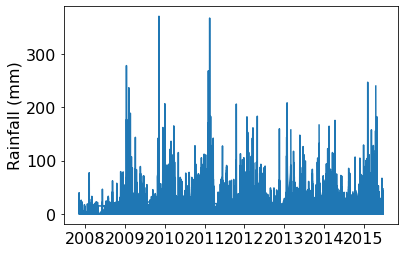

In [73]:
plt.plot(df_train["Date"], df_train["Rainfall"]);
plt.ylabel("Rainfall (mm)");

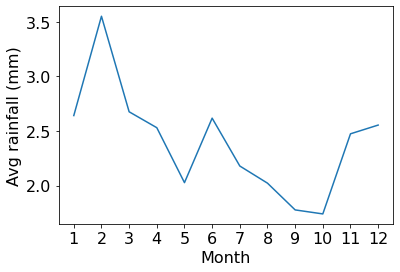

In [74]:
monthly_avg_rainfall = df_train.groupby("Month")["Rainfall"].mean()
plt.plot(monthly_avg_rainfall);
plt.xticks(np.arange(1,13).astype(int));
plt.ylabel("Avg rainfall (mm)");
plt.xlabel("Month");

In [75]:
df_train.sort_values(by="Date", ascending=False)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month,Winter
141478,2015-06-30,Uluru,6.8,21.1,0.0,NaN,NaN,ESE,35.0,ESE,...,1025.2,3.0,NaN,10.6,20.2,No,0.0,No,6,True
138387,2015-06-30,Darwin,18.3,32.6,0.0,6.0,11.0,ESE,37.0,E,...,1013.3,1.0,1.0,24.0,31.6,No,0.0,No,6,True
96224,2015-06-30,Adelaide,7.2,13.8,0.0,NaN,NaN,SW,17.0,ENE,...,1029.5,NaN,NaN,10.1,12.7,No,0.0,No,6,True
55977,2015-06-30,Ballarat,-0.3,10.5,0.0,NaN,NaN,S,26.0,NaN,...,1027.7,NaN,8.0,4.7,9.3,No,0.4,No,6,True
93135,2015-06-30,Townsville,20.0,27.4,0.4,6.6,4.6,SE,46.0,SE,...,1019.2,7.0,6.0,23.5,26.2,No,0.0,No,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44355,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,1018.5,7.0,7.0,11.1,15.4,Yes,0.0,No,11,False
44354,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,1007.0,2.0,7.0,13.5,14.1,Yes,2.8,Yes,11,False
44353,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,1007.2,8.0,7.0,15.4,20.2,Yes,39.8,Yes,11,False
44352,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,1008.4,5.0,3.0,17.5,25.7,Yes,3.6,Yes,11,False


- This pattern is pretty surprising to me - why is June rainy but May and August are less so?
- But, Australia is a huge country. Perhaps we should drill down to particular locations:

In [76]:
df_train_canberra  = df_train.query('Location == "Canberra"')

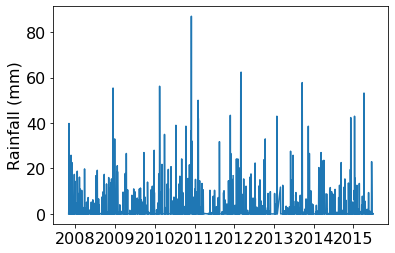

In [77]:
plt.plot(df_train_canberra["Date"], df_train_canberra["Rainfall"]);
plt.ylabel("Rainfall (mm)");

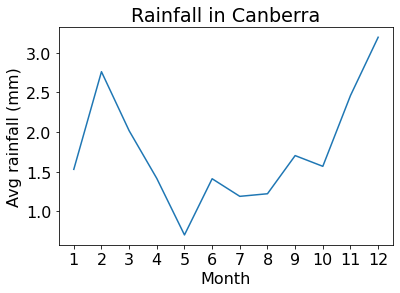

In [78]:
plt.plot(df_train_canberra.groupby("Month")["Rainfall"].mean());
plt.xticks(np.arange(1,13).astype(int));
plt.ylabel("Avg rainfall (mm)");
plt.xlabel("Month");
plt.title("Rainfall in Canberra");

- This looks somewhat cleaner but also pretty surprising - why is December so much higher than January?
- This is called _seasonality_.
- Why was the month feature not that useful? Perhaps this was already captured in the other features.
  - But also the encoding wasn't ideal.

#### Periodic encoding

- We can also try a periodic encoding.
- This works because we know the periodicity (annual).
- We can use a sin and cos with period 1 year.
- You can shift the period by adding together $\sin(x)$ and $\cos(x)$:

In [79]:
WINTER_MONTHS = {5,6,7,8,9}
df_train = df_train.assign(Winter=df_train["Month"].isin(WINTER_MONTHS))
df_test  = df_test.assign( Winter=df_test[ "Month"].isin(WINTER_MONTHS))

In [80]:
df_train = df_train.assign(Month_sin = np.sin(2*np.pi*df_train["Month"]/12))
df_train = df_train.assign(Month_cos = np.cos(2*np.pi*df_train["Month"]/12))

df_test = df_test.assign(Month_sin = np.sin(2*np.pi*df_test["Month"]/12))
df_test = df_test.assign(Month_cos = np.cos(2*np.pi*df_test["Month"]/12))

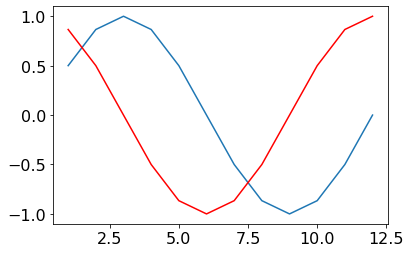

In [81]:
month = np.arange(1,13)
enc_sin = np.sin(2*np.pi*month/12)
enc_cos = np.cos(2*np.pi*month/12)
plt.plot(month,enc_sin);
plt.plot(month,enc_cos, 'r');

In [82]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Month_sin", "Month_cos"], 
        categorical_features, 
        drop_features + ["Month", "Winter"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [83]:
lr_pipe.fit(df_train, y_train);

In [84]:
lr_pipe.score(df_train, y_train)

0.8499097691205745

In [85]:
lr_pipe.score(df_test, y_test)

0.8436770343893228

In [86]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc[["Month_sin", "Month_cos"]]

,Coef
Month_sin,-0.090787
Month_cos,-0.127540


**From Piazza last year**

Q: How to interpret coefficients for periodic encoded features?

A: They are both negative, so it means the price is higher when sin(2 pi month / 12) is lower and when cos(2 pi month / 12) is lower. In fact, since this is a linear model, we can just combine them: it means the price is higher when -0.016 sin(2 pi month / 12) - 0.013 cos(2 pi month / 12) is high. You can plot this function. I plotted it - see attached image. It shows that the predicted price is higher roughly from months 5-11, meaning May-November, with the lowest price falling around Jan-Feb and the highest price around August.

Optional note: by following trigonometric identities, we can see that learning  $A\sin(x)+B\cos(x)$  is the same as learning  $C\sin(x-\phi)$, or in other words a phase-shifted sine wave. 

However, all this only applies because it's a linear model. For something like a random forest, these coefficients would be harder to interpret.


#### Encoding average monthly rainfall 

We can also try encoding the average rainfall for that month a a feature:

In [87]:
monthly_avg_rainfall = df_train.groupby("Month")["Rainfall"].mean()
monthly_avg_rainfall

Month
1     2.641089
2     3.550847
3     2.675817
4     2.530029
5     2.026871
6     2.617369
7     2.179104
8     2.022084
9     1.777074
10    1.740375
11    2.474031
12    2.554032
Name: Rainfall, dtype: float64

In [88]:
df_train = df_train.assign(Monthly_rainfall = df_train["Date"].apply(lambda x: monthly_avg_rainfall[x.month]))
df_test = df_test.assign(Monthly_rainfall = df_test["Date"].apply(lambda x: monthly_avg_rainfall[x.month]))

In [89]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Monthly_rainfall"], 
        categorical_features, 
        drop_features + ["Month", "Winter", "Month_sin", "Month_cos"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [90]:
lr_pipe.fit(df_train, y_train);

In [91]:
lr_pipe.score(df_train, y_train)

0.8500213949507917

In [92]:
lr_pipe.score(df_test, y_test)

0.844484160156813

In [93]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc["Monthly_rainfall"]

Coef   -0.057041
Name: Monthly_rainfall, dtype: float64

- Hmm, it's a bit worrying that this coefficient is negative...
- Unless I have a bug in my code, this is a prime example of the dangers of interpreting coefficients too literally. 
- If we trained a model with _only_ this feature:

In [94]:
monthly_rain = df_train["Date"].apply(lambda x: monthly_avg_rainfall[x.month]).values[:,None]

In [95]:
lr = LogisticRegression(max_iter=1000)
lr.fit(monthly_rain, y_train)
lr.coef_

array([[-0.01646627]])

- Even here we get a negative coefficient, very bizarre.
- We'll get a sensible result in a second:

#### Average monthly rainfall by location

In [96]:
avg_monthly_rainfall_by_loc = df_train.groupby(["Month", "Location"])["Rainfall"].mean()

In [97]:
df_train = df_train.assign(Monthly_rainfall_at_loc = df_train.groupby(["Month", "Location"])["Rainfall"].transform('mean'))
df_test = df_test.assign(Monthly_rainfall_at_loc = df_test.groupby(["Month", "Location"])["Rainfall"].transform('mean'))

In [98]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Monthly_rainfall_at_loc"], 
        categorical_features, 
        drop_features + ["Month", "Winter", "Month_sin", "Month_cos", "Monthly_rainfall"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [99]:
lr_pipe.fit(df_train, y_train);

In [100]:
lr_pipe.score(df_train, y_train)

0.8508306822198657

In [101]:
lr_pipe.score(df_test, y_test)

0.8452336340837682

In [102]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc["Monthly_rainfall_at_loc"]

Coef    0.216485
Name: Monthly_rainfall_at_loc, dtype: float64

At least here we get a positive coefficient

![](img/mike_phew.png)

## Break (5 min)

REMINDER TO RESUME RECORDING

## Lag-based features (15 min)

- Currently we're using features about today to predict tomorrow's rainfall.
- But, what if tomorrow's rainfall is also related to yesterday's features, or the day before?
  - This is called a _lagged_ feature.
- In time series analysis, we'd look at something called an [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF), but we won't go into that here.
- Instead, we can just add those features:

In [103]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [104]:
df_train

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141474,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,37.0,1031.5,1027.6,NaN,NaN,8.8,17.2,No,0.0,No
141475,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,40.0,1029.9,1026.0,NaN,NaN,7.0,15.7,No,0.0,No
141476,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,39.0,1028.7,1025.0,NaN,3.0,8.9,18.0,No,0.0,No
141477,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,37.0,1027.2,1023.8,6.0,7.0,11.7,21.5,No,0.0,No


- It looks like the dataframe is already sorted by Location and then by date for each Location.
- We could have done this ourselves with

In [105]:
# df_train.sort_values(by=["Location", "Date"])

But make sure to also sort the targets (i.e. do this before preprocessing).

In [120]:
def create_lag_feature(df, orig_feature, lag):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int."""
    # note: pandas .shift() kind of does this for you already, but oh well I already wrote this code
    
    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    for location, df_location in new_df.groupby("Location"): # Each location is its own time series
        new_df.loc[df_location.index[lag:],new_feature_name] = df_location.iloc[:-lag][orig_feature].values
    return new_df

In [121]:
df_train = create_lag_feature(df_train, "Rainfall", 1)

In [122]:
df_train[["Date", "Location", "Rainfall", "Rainfall_lag1"]].head(20)

,Date,Location,Rainfall,Rainfall_lag1
0,2008-12-01,Albury,0.6,NaN
1,2008-12-02,Albury,0.0,0.6
2,2008-12-03,Albury,0.0,0.0
3,2008-12-04,Albury,0.0,0.0
4,2008-12-05,Albury,1.0,0.0
5,2008-12-06,Albury,0.2,1.0
6,2008-12-07,Albury,0.0,0.2
7,2008-12-08,Albury,0.0,0.0
8,2008-12-09,Albury,0.0,0.0
9,2008-12-10,Albury,1.4,0.0


In [123]:
df_train[["Date", "Location", "Rainfall", "Rainfall_lag1"]][2285:2295]

,Date,Location,Rainfall,Rainfall_lag1
2285,2015-06-26,Albury,0.2,1.0
2286,2015-06-27,Albury,0.0,0.2
2287,2015-06-28,Albury,0.2,0.0
2288,2015-06-29,Albury,0.0,0.2
2289,2015-06-30,Albury,0.0,0.0
3011,2009-01-01,BadgerysCreek,0.0,NaN
3012,2009-01-02,BadgerysCreek,0.0,0.0
3013,2009-01-03,BadgerysCreek,0.0,0.0
3014,2009-01-04,BadgerysCreek,0.0,0.0
3015,2009-01-05,BadgerysCreek,0.0,0.0


- Looks good.

- Question: is it OK to do this to the test set? Discuss.

<br><br><br><br><br><br>

- It's fine if you would have this information available in deployment.
- If we're just forecasting the next day, we should.
- Let's include it for now.

Another question: is there a difference between doing this and then splitting, vs. splitting and then doing this?

<br><br><br><br><br><br>

- Answer: a tiny difference: the first day of the test set, for each location, will have a `NaN`. 
  - That might actually be too strict.
  - It should be fine to do this before splitting.

In [124]:
df_rain_modified = create_lag_feature(df_rain, "Rainfall", 1)

In [125]:
df_train = df_rain_modified.query('Date <= 20150630')
df_test  = df_rain_modified.query('Date >  20150630')

In [131]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Rainfall_lag1"], 
        categorical_features, 
        drop_features)

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [132]:
lr_pipe.fit(df_train, y_train);

In [135]:
lr_pipe.score(df_train, y_train)

0.8502260423061897

In [136]:
lr_pipe.score(df_test, y_test)

0.844426508316278

In [137]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.242542
RainToday_?,0.918470
Pressure9am,0.866227
Location_Witchcliffe,0.728622
WindGustSpeed,0.720533
...,...
RainToday_No,-0.722207
Location_Katherine,-0.728617
Location_Wollongong,-0.749250
Location_MountGinini,-0.965463


In [138]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

,Coef
Rainfall,0.081072
Rainfall_lag1,0.008303


- We could also create a lagged version of the target.
- In fact, this dataset already has that built in! `RainToday` is the lagged version of the target `RainTomorrow`.
- We could also created lagged version of other features, or more lags

In [139]:
df_rain_modified = create_lag_feature(df_rain, "Rainfall", 1)
df_rain_modified = create_lag_feature(df_rain_modified, "Rainfall", 2)
df_rain_modified = create_lag_feature(df_rain_modified, "Rainfall", 3)
df_rain_modified = create_lag_feature(df_rain_modified, "Humidity3pm", 1)

In [140]:
df_rain_modified[['Date', 'Location', 'Rainfall', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm', 'Humidity3pm_lag1']].head(10)

,Date,Location,Rainfall,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Humidity3pm,Humidity3pm_lag1
0,2008-12-01,Albury,0.6,NaN,NaN,NaN,22.0,NaN
1,2008-12-02,Albury,0.0,0.6,NaN,NaN,25.0,22.0
2,2008-12-03,Albury,0.0,0.0,0.6,NaN,30.0,25.0
3,2008-12-04,Albury,0.0,0.0,0.0,0.6,16.0,30.0
4,2008-12-05,Albury,1.0,0.0,0.0,0.0,33.0,16.0
5,2008-12-06,Albury,0.2,1.0,0.0,0.0,23.0,33.0
6,2008-12-07,Albury,0.0,0.2,1.0,0.0,19.0,23.0
7,2008-12-08,Albury,0.0,0.0,0.2,1.0,19.0,19.0
8,2008-12-09,Albury,0.0,0.0,0.0,0.2,9.0,19.0
9,2008-12-10,Albury,1.4,0.0,0.0,0.0,27.0,9.0


Note the pattern of `NaN` values. 

In [141]:
df_train = df_rain_modified.query('Date <= 20150630')
df_test  = df_rain_modified.query('Date >  20150630')

In [142]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ['Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm_lag1'], 
        categorical_features, 
        drop_features)

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [143]:
lr_pipe.fit(df_train, y_train);

In [144]:
lr_pipe.score(df_train, y_train)

0.8514818328961322

In [145]:
lr_pipe.score(df_test, y_test)

0.8460119339309907

In [146]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
Humidity3pm,1.278554
RainToday_?,0.903025
Pressure9am,0.895413
Location_Witchcliffe,0.745507
WindGustSpeed,0.706832
...,...
Location_Wollongong,-0.641508
Location_Katherine,-0.747221
RainToday_No,-0.758927
Location_MountGinini,-0.869530


In [147]:
lr_coef.loc[['Rainfall', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm', 'Humidity3pm_lag1']]

,Coef
Rainfall,0.108507
Rainfall_lag1,0.023072
Rainfall_lag2,0.018276
Rainfall_lag3,0.017810
Humidity3pm,1.278554
Humidity3pm_lag1,-0.267483


## Forecasting further into the future (10 min)

- Let's say we want to predict 7 days into the future instead of one day.
- There are a few main approaches here:

1. Train a separate model for each number of days. E.g. one model that predicts RainTomorrow, another model that predicts RainIn2Days, etc. We can build these datasets.
2. Use a multi-output model that jointly predicts RainTomorrow, RainIn2Days, etc. However, multi-output models are outside the scope of CPSC 330. 
3. Use one model and sequentially predict using a `for` loop. However, this requires predicting _all_ features into a model so may not be that useful here.

So, I'll recommend Approach 1 to you, even though it's a bit unwieldy. 

- To briefly dig into approach 3, this is easier to understand for a univariate (one feature) time series. 
- To dig into this we'll look at the [Retail Sales of Clothing and Clothing Accessory Stores dataset](https://fred.stlouisfed.org/series/MRTSSM448USN) made available by the Federal Reserve Bank of St. Louis.

In [171]:
retail_df = pd.read_csv('data/retail_sales_timeseries.csv', parse_dates=["DATE"])
retail_df.columns=["date", "sales"]

In [172]:
retail_df.head()

,date,sales
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [174]:
retail_df['date'].min()

Timestamp('1992-01-01 00:00:00')

In [175]:
retail_df['date'].max()

Timestamp('2020-08-01 00:00:00')

In [176]:
retail_df_train = retail_df.query('date <= 20170101')
retail_df_test  = retail_df.query('date >  20170101')

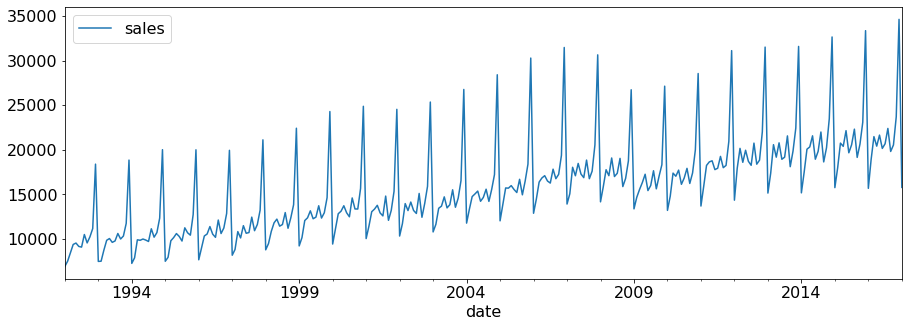

In [186]:
retail_df_train.plot(x="date", y="sales", figsize=(15,5));

We can create a dataset using purely lag features.

In [188]:
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})

In [205]:
retail_lag_5 = lag_df(retail_df, 5, ["sales"])
retail_train_5 = retail_lag_5.query('date <= 20170101')
retail_test_5  = retail_lag_5.query('date >  20170101')
retail_train_5

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5
0,1992-01-01,6938,NaN,NaN,NaN,NaN,NaN
1,1992-02-01,7524,6938.0,NaN,NaN,NaN,NaN
2,1992-03-01,8475,7524.0,6938.0,NaN,NaN,NaN
3,1992-04-01,9401,8475.0,7524.0,6938.0,NaN,NaN
4,1992-05-01,9558,9401.0,8475.0,7524.0,6938.0,NaN
...,...,...,...,...,...,...,...
296,2016-09-01,19816,22394.0,20676.0,20157.0,21648.0,20412.0
297,2016-10-01,20544,19816.0,22394.0,20676.0,20157.0,21648.0
298,2016-11-01,23704,20544.0,19816.0,22394.0,20676.0,20157.0
299,2016-12-01,34611,23704.0,20544.0,19816.0,22394.0,20676.0


- Now, if we drop the "date" column we have a target ("sales") and 5 features (the previous 5 days of sales).
- We need to impute/drop the missing values and then we can fit a model to this. I will just drop for convenience:

In [192]:
retail_train_5 = retail_train_5[5:].drop(columns=["date"])
retail_train_5

,sales,sales-1,sales-2,sales-3,sales-4,sales-5
5,9182,9558.0,9401.0,8475.0,7524.0,6938.0
6,9103,9182.0,9558.0,9401.0,8475.0,7524.0
7,10513,9103.0,9182.0,9558.0,9401.0,8475.0
8,9573,10513.0,9103.0,9182.0,9558.0,9401.0
9,10254,9573.0,10513.0,9103.0,9182.0,9558.0
...,...,...,...,...,...,...
296,19816,22394.0,20676.0,20157.0,21648.0,20412.0
297,20544,19816.0,22394.0,20676.0,20157.0,21648.0
298,23704,20544.0,19816.0,22394.0,20676.0,20157.0
299,34611,23704.0,20544.0,19816.0,22394.0,20676.0


In [193]:
retail_train_5_X = retail_train_5.drop(columns=["sales"])
retail_train_5_y = retail_train_5["sales"]

In [195]:
from sklearn.ensemble import RandomForestRegressor

In [196]:
retail_model = RandomForestRegressor()
retail_model.fit(retail_train_5_X, retail_train_5_y);

Given this, we can now predict the sales for the first test point

In [210]:
preds = retail_model.predict(retail_test_5.drop(columns=["date", "sales"]))
preds

array([18278.12, 20553.37, 20989.32, 21708.42, 20368.43, 21642.85,
       21869.5 , 28595.5 , 21270.72, 23121.23, 31110.26, 16319.51,
       18286.9 , 21599.02, 22241.34, 21737.82, 29970.93, 20677.14,
       21911.52, 31835.16, 21712.36, 21373.02, 18433.44, 16308.91,
       18703.06, 20565.26, 21657.26, 21410.15, 28732.25, 21718.72,
       21271.13, 31974.74, 21991.43, 21583.08, 28784.18, 16131.25,
       18850.3 , 21898.62, 13713.42, 11612.23, 11075.84, 15411.6 ,
       13144.31])

In [214]:
retail_test_5_preds = retail_test_5.assign(predicted_sales = preds)
retail_test_5_preds.head()

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,predicted_sales
301,2017-02-01,17900,15791.0,34611.0,23704.0,20544.0,19816.0,18278.12
302,2017-03-01,21217,17900.0,15791.0,34611.0,23704.0,20544.0,20553.37
303,2017-04-01,21052,21217.0,17900.0,15791.0,34611.0,23704.0,20989.32
304,2017-05-01,21831,21052.0,21217.0,17900.0,15791.0,34611.0,21708.42
305,2017-06-01,20527,21831.0,21052.0,21217.0,17900.0,15791.0,20368.43


- Ok, that is fine, but what if we want to predict 7 days in the future? 
- Well, we would not have access to our features!! We don't yet know the previous day's sales, or 2 days prior! 
- So we can use "Approach 3" mentioned earlier: predict these values and then pretend they are true!
- For simplicity, say today is Monday

1. Predict Tuesday's sales
2. Then, to predict for Wednesday, we need to know Tuesday's sales. Use our _prediction_ for Tuesday as the truth.
3. Then, to predict for Thursday, we need to know Tue and Wed sales. Use our predictions.
4. Etc etc.

Let's take a look at [Tom's timeseries tutorial](https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb) for what this looks like.

## Trends (5 min)

- I kind of regret picking the Rain in Australia dataset because it has a binary target value.
- There are some important concepts in time series that rely on having a continuous target (like we do in the retail sales example above).
- Part of that is the idea of seasonality and trends.
- These are mostly taken care of by our feature engineering of the data variable, but there's something important left to discuss.

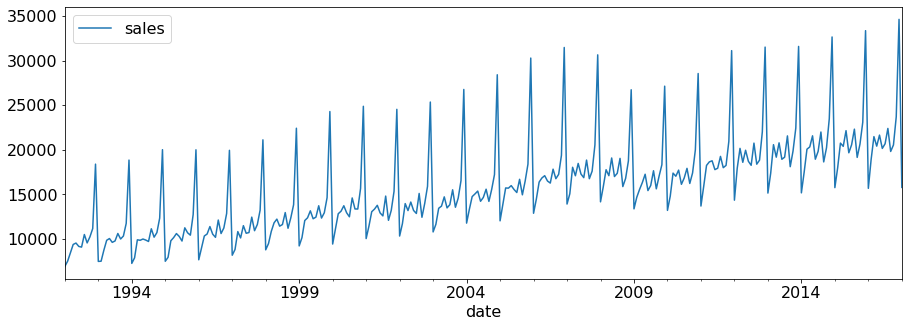

In [215]:
retail_df_train.plot(x="date", y="sales", figsize=(15,5));

- It looks like there's a **trend** here - the sales are going up over time. 
- This is somewhat captured by the fact that you can look at the last 5 time points, which will also be higher.
- But if you want to forecast much farther into the future, nothing in our model accounts for the trend. 
- This is seen in the forecasts in Tom's notebook. 

Let's say we encoded the date as a feature in days like this:

In [221]:
first_day_retail = retail_train_5["date"].min()

retail_train_5.assign(Days_since=retail_train_5["date"].apply(lambda x: (x-first_day_retail).days))

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,Days_since
0,1992-01-01,6938,NaN,NaN,NaN,NaN,NaN,0
1,1992-02-01,7524,6938.0,NaN,NaN,NaN,NaN,31
2,1992-03-01,8475,7524.0,6938.0,NaN,NaN,NaN,60
3,1992-04-01,9401,8475.0,7524.0,6938.0,NaN,NaN,91
4,1992-05-01,9558,9401.0,8475.0,7524.0,6938.0,NaN,121
...,...,...,...,...,...,...,...,...
296,2016-09-01,19816,22394.0,20676.0,20157.0,21648.0,20412.0,9010
297,2016-10-01,20544,19816.0,22394.0,20676.0,20157.0,21648.0,9040
298,2016-11-01,23704,20544.0,19816.0,22394.0,20676.0,20157.0,9071
299,2016-12-01,34611,23704.0,20544.0,19816.0,22394.0,20676.0,9101


- Now, let's say we use all these features (the lagged version of the target and also `Days_since`.
- If we use **linear regression** we'll learn a coefficient for `Days_since`. 
  - If that coefficient is positive, it predicts unlimited growth forever. That may not be what you want? It depends.
- If we use a **random forest**, we'll just be doing splits from the training set, e.g. "if `Days_since` > 9100 then do this".
  - There will be no splits for later time points because there is no training data there.
  - Thus tree-based models cannot model trends.
  - This is really important to know!!
- Often, we model the trend separately and use the random forest to model a de-trended time series.

## What did we not cover? (5 min)

- A huge amount!

#### Traditional time series approaches

- Time series analysis is a huge field of its own (notice a pattern here?)
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We will take a different route in this course, and stick to our supervised learning tools.

#### Deep learning 

- Recently, deep learning has been very successful too.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - These are not covered in CPSC 340, but I believe they are in 540 (soon to be renamed 440).
  - [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) especially have shown a lot of promise in this type of task.
  - [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a blog post about LSTMs.
  - [Here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) is the documentation for the LSTM in tf.keras.

#### Types of problems involving time series

- A single label associated with an entire time series. 
  - We had that with images earlier on, you could have the same for a time series.
  - E.g., for fraud detection, labelling each transaction as fraud/normal vs. labelling a person as bad/good based on their entire history.
  - There are various approaches that can be used for this type of problem, including CNNs (Lecture 14), LSTMs, and non deep learning methods.
- Inference problems.
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
 - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month / looking at seasonality.
  - Some of our approaches would not make sense, like the lags.
  - Perhaps the measurements could be binned into equally spaced bins, or something.
  - This is more of a hassle.

#### Other software package

- One good one to know about is [Prophet](https://facebook.github.io/prophet/docs/quick_start.html).

#### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.
  - We may still have a class on feature engineering... TBD.

## T/F questions (Piazza)

1. The rain in Australia dataset contains a single time series; that is, each date has a unique row associated with it.
2. A reasonable approach to encoding the date would be one-hot encoding the days of the year (from 1-365).
3. It is better to OHE the month than to encode it as an integer (i.e. ordinal).
4. It is important to train/test split before we create our lagged features.
5. If we have a feature with lag 3 in our dataset, that feature will be missing if we try to forecast 5 days into the future.

<br><br><br><br><br><br>